In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D , Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import itertools
import os
import matplotlib.pyplot as plt
import cv2
import random
import shutil
import requests
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
real_path = 'data/real'
fake_path = 'data/fake'


In [3]:
base_dir = '/data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

for directory in [train_dir, val_dir, test_dir]:
    os.makedirs(os.path.join(directory, 'real'), exist_ok=True)
    os.makedirs(os.path.join(directory, 'fake'), exist_ok=True)

In [4]:
def split_data(SOURCE, TRAINING, VALIDATION, TEST, split_size=0.7, val_size=0.15):
    files = [f for f in os.listdir(SOURCE) if os.path.isfile(os.path.join(SOURCE, f))]
    
    train_files, test_files = train_test_split(files, test_size=1-split_size, random_state=42)
    val_files, test_files = train_test_split(test_files, test_size=1 - val_size / (1 - split_size), random_state=42)

    for file_name in train_files:
        shutil.copy(os.path.join(SOURCE, file_name), os.path.join(TRAINING, file_name))
    for file_name in val_files:
        shutil.copy(os.path.join(SOURCE, file_name), os.path.join(VALIDATION, file_name))
    for file_name in test_files:
        shutil.copy(os.path.join(SOURCE, file_name), os.path.join(TEST, file_name))


In [5]:
split_data(real_path, os.path.join(train_dir, 'real'), os.path.join(val_dir, 'real'), os.path.join(test_dir, 'real'))
split_data(fake_path, os.path.join(train_dir, 'fake'), os.path.join(val_dir, 'fake'), os.path.join(test_dir, 'fake'))

In [6]:
batch_size = 16
img_size = (224, 224)

data_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.4,1.5],
    zoom_range=0.3,
    rotation_range=40,
    fill_mode='nearest'
)

train_batches = data_gen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
)

valid_batches = data_gen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
)

test_batches = data_gen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 26139 images belonging to 2 classes.
Found 5943 images belonging to 2 classes.
Found 5934 images belonging to 2 classes.


In [7]:
class_labels = np.unique(train_batches.classes) 
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=class_labels,
    y=train_batches.classes 
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

Class Weights: {0: 0.7144926743931773, 1: 1.6655409710717473}


In [8]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [9]:
for layer in base_model.layers:
    layer.trainable = False

In [10]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    Dense(units=128, activation='relu'),
    Dropout(0.2),
    Dense(units=64, activation='relu'),
    Dropout(0.2),
    layers.Dense(2, activation='softmax') 
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
history = model.fit(x=train_batches,
    validation_data=valid_batches,
    epochs=5,
    class_weight=class_weights_dict,
    verbose=1
)

Epoch 1/5
1634/1634 [==============================] - 787s 482ms/step - loss: 0.3630 - accuracy: 0.8554 - val_loss: 0.2968 - val_accuracy: 0.8851
Epoch 2/5
1634/1634 [==============================] - 786s 481ms/step - loss: 0.3397 - accuracy: 0.8661 - val_loss: 0.2943 - val_accuracy: 0.8839
Epoch 3/5
1634/1634 [==============================] - 790s 484ms/step - loss: 0.3205 - accuracy: 0.8742 - val_loss: 0.2804 - val_accuracy: 0.8876
Epoch 4/5
1634/1634 [==============================] - 851s 521ms/step - loss: 0.3173 - accuracy: 0.8770 - val_loss: 0.2903 - val_accuracy: 0.8894
Epoch 5/5
1634/1634 [==============================] - 893s 547ms/step - loss: 0.3094 - accuracy: 0.8826 - val_loss: 0.2703 - val_accuracy: 0.8940


In [16]:
history_dict = history.history
model_loss = pd.DataFrame(history_dict)

In [17]:
model_loss.to_csv("mobilenet_training_history_5epoch.csv", index=False)

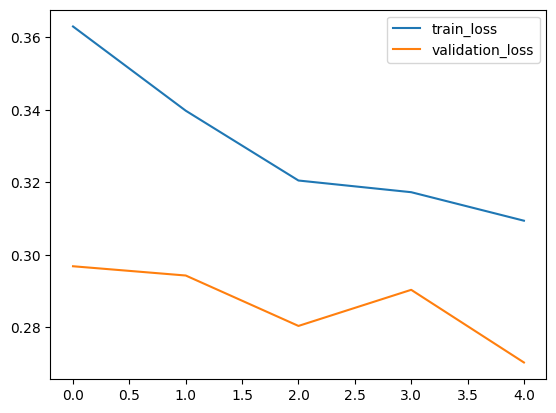

In [18]:
plt.plot(model_loss['loss'],label = 'train_loss')
plt.plot(model_loss['val_loss'],label = 'validation_loss')
plt.legend()
plt.show() 

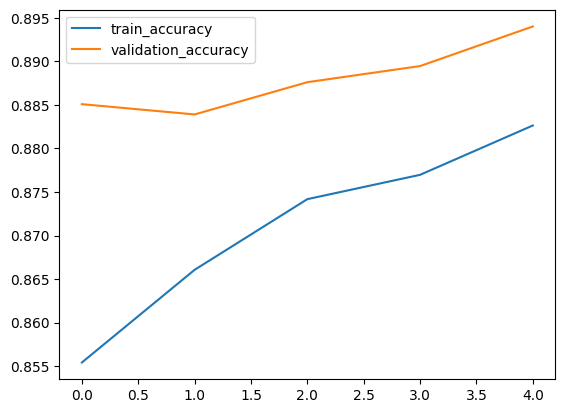

In [19]:
plt.plot(model_loss['accuracy'],label = 'train_accuracy')
plt.plot(model_loss['val_accuracy'],label = 'validation_accuracy')
plt.legend()
plt.show()

In [20]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=1)

371/371 [==============================] - 196s 525ms/step


In [21]:
print(classification_report(test_batches.classes,np.argmax(predictions, axis = -1)))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      4153
           1       0.88      0.77      0.82      1781

    accuracy                           0.90      5934
   macro avg       0.89      0.86      0.87      5934
weighted avg       0.90      0.90      0.90      5934



## Test with image from internet

In [22]:
test2_dir = 'data/test2/'

In [23]:
test_batches2 = data_gen.flow_from_directory(
    test2_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 40 images belonging to 2 classes.


In [24]:
predictions = model.predict(x=test_batches2, steps=len(test_batches2), verbose=1)

C:\Users\Phattaradanai\anaconda3\envs\tenserflowgpu\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 2s 616ms/step


In [25]:
print(classification_report(test_batches2.classes,np.argmax(predictions, axis = -1)))

              precision    recall  f1-score   support

           0       0.59      0.95      0.73        20
           1       0.88      0.35      0.50        20

    accuracy                           0.65        40
   macro avg       0.73      0.65      0.62        40
weighted avg       0.73      0.65      0.62        40



In [26]:
model.save('modelmobilenet5epoch.h5')